In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
pd.set_option('display.max_rows', 1000) 

df = pd.read_csv('ivf_data.csv') 

# converts valid date entries to date, changes non-valid entries (. and nan) to NaT 
df["DATE"] = pd.to_datetime(df["DATE"], infer_datetime_format=True, errors='coerce') 

 
df = df.iloc[0:314,:] 

In [3]:
df = df[df["BLAST_D8"]!="."]

In [70]:
df

,NUM,DATE,SAMPLE,REPLICATE,ANIMAL,BATCH,SUB_1_RP,SUB_2_H,SUB_3_LS,SUB_4_LP,...,LIN,MOTILE_PCT,PROGRESSIVE_PCT,RAPID_PCT,MEDIUM_PCT,SLOW_PCT,STATIC_PCT,CLIV,BLAST_D8,CELLS_COUNT
0,1.0,2015-07-16,135,26,PANDIAH,1305,26.32,15.76,21.64,36.29,...,44.0,45.0,37.0,44.0,1.0,6.0,49.0,82.716,33.333,188.750
1,2.0,2015-08-21,180,33,PANDIAH,1305,26.32,15.76,21.64,36.29,...,48.0,74.0,60.0,70.0,4.0,9.0,17.0,79.012,16.049,.
2,3.0,2015-08-28,191,34,PANDIAH,1305,26.32,15.76,21.64,36.29,...,47.0,41.0,30.0,37.0,3.0,26.0,34.0,76.923,20.253,184.500
3,4.0,2015-09-15,205,36,PANDIAH,130503,26.32,15.76,21.64,36.29,...,69.0,50.0,15.0,18.0,31.0,37.0,13.0,77.027,27.027,.
4,5.0,2015-10-01,227,38,PANDIAH,130503,26.32,15.76,21.64,36.29,...,51.0,63.0,54.0,59.0,4.0,16.0,22.0,76.829,39.024,169.500
5,6.0,2015-10-06,233,39,PANDIAH,130503,26.32,15.76,21.64,36.29,...,47.0,59.0,47.0,54.0,5.0,14.0,27.0,66.154,25.806,184.889
6,7.0,2015-10-08,240,40,PANDIAH,130503,26.32,15.76,21.64,36.29,...,60.0,40.0,29.0,31.0,9.0,3.0,57.0,82.192,34.247,207.000
7,8.0,2015-10-20,248,41,PANDIAH,130503,26.32,15.76,21.64,36.29,...,51.0,43.0,32.0,36.0,7.0,20.0,37.0,67.606,23.611,263.500
8,9.0,2015-10-29,261,42,PANDIAH,130503,26.32,15.76,21.64,36.29,...,61.0,43.0,40.0,41.0,2.0,2.0,55.0,61.765,23.529,154.143
9,10.0,2015-11-19,269,43,PANDIAH,130503,26.32,15.76,21.64,36.29,...,64.0,36.0,32.0,34.0,2.0,8.0,56.0,81.690,35.211,.


In [ ]:
""""
df_2 = df.loc[:,["MOTILE_PCT"]]
df_2["AI"] = df.loc[:,["AI"]]
blast = pd.to_numeric(df["BLAST_D8"],errors='coerce')
new.loc[blast > 25, "class"] = 1
df_2.loc[blast < 25, "class"] = -1
""""

MAKING THE SUBGROUPS: STEPS (three-step statistical analysis proposed by Núñez-Martínez, Moran and Peña (2006)) 

components they used: VAP, VSL, VCL, ALH, BCF, STR, LIN, WOB and DANCE <br>
out of those, we have: VAP, VSL, VCL, ALH, BCF, STR, LIN <br>
and can calculate the other two: WOB- Wobble = (VAP/VCL) x 100; DNC- Dance = VCL x ALH. <br>

1. PCA 
    Three main components: PC1 presents nonlinear fast movements, PC2 represents slow and linear movements and PC3 presents oscillatory movements.
2. K-MEANS MODEL using Euclidean Multivariate Distance
3. Discriminant method to reduce number of clusters (Hierarchical dendogram analysis??)

(4. Comparison of subgroups in each group via chi-square test??)

conduct this for each of the four groups HIGH CLEAVAGE, LOW CLEAVAGE, HIGH BLASTOCYST RATE, LOW BLASTOCYST RATE <br>
compare groups <br>
for new sample, see if can predict. <br>


In [14]:
# Isolate motility features and add new ones, drop those with value .
motility = df.loc[:,["VAP"]]
motility["VSL"] = pd.to_numeric(df["VSL"])
motility["VCL"] = pd.to_numeric(df["VCL"])
motility["ALH"] = pd.to_numeric(df["ALH"])
motility["BCF"] = pd.to_numeric(df["BCF"])
motility["STR"] = pd.to_numeric(df["STR"])
motility["LIN"] = pd.to_numeric(df["LIN"])
motility["VAP"] = pd.to_numeric(motility["VAP"])
motility["WOB"] = (motility["VAP"]/motility["VCL"]) * 100
motility["DNC"] = motility["VCL"] * motility["ALH"]

# get results
blasrate = pd.to_numeric(df["BLAST_D8"])
cleavage = pd.to_numeric(df["CLIV"])

# create four groups with entries HB/LB = high/low blastocyst rate, HC/LC = high/low cleavage
HB = motility[blasrate > np.mean(blasrate)]
LB = motility[blasrate <= np.mean(blasrate)]
HC = motility[cleavage > np.mean(cleavage)]
LB = motility[cleavage <= np.mean(cleavage)]

In [4]:
from sklearn import preprocessing
def norm(df):
    # Normalises by removing the mean and scaling to unit variance
	scaler = preprocessing.StandardScaler()
	x_scaled = scaler.fit_transform(df)
	df_normalized = pd.DataFrame(x_scaled)
	return df_normalized

In [68]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

def calc_pca(df, colnames): #to three components!
    pca = PCA(n_components=3)
    train_trans = pca.fit_transform(df)
    components = pca.components_.T
    for n in range(3):
        idx = (-abs(components[:,n])).argsort()[:5]
        print("For principal component", n+1)
        print("Most relevant features are", colnames[idx])
        print("With respective values", components[idx,n])
    #fig = plt.figure()
    #ax = fig.gca(projection='3d')
    #ax.scatter(train_trans[:,0], train_trans[:,1], train_trans[:,2])
    
    return train_trans, components

def show_pca_components(pca_components, colnames): #for three main components! 
    labels = colnames

    x = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars
    
    pca_components = abs(pca_components)
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width, pca_components[:,0], width, label='PC1')
    rects2 = ax.bar(x, pca_components[:,1], width, label="PC2")
    rects3 = ax.bar(x + width, pca_components[:,2], width, label='PC3')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Eigenvector value (absolute)')
    ax.set_title('Value of eigenvector of the Principal Components for each variable')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()

    plt.show()    
    
    
    
def clustering(df, num_centroids):
    kmeans = KMeans(num_centroids).fit(df)
    labels = kmeans.labels_    
    return labels

# in progress - plot a graph w mean and std of each value for each group.
def plot_characteristics(df, labels, clusters, colnames):
    #fig, axis = plt.subplots(len(colnames),1, figsize=(15,15))
    summary = np.zeros((clusters*len(colnames), 4))
    colours = ["r", "k", "b", "g"]
    for c in range(clusters):
        group = df[labels == c]
        means = np.mean(group, axis=0)
        stds = np.std(group, axis=0)
        print("for cluster", c)
        print(means.transpose())
        print(stds.transpose())
        """"  
        var = 0
        for ax in axis.flat:
            ax.set_title(colnames[var])
            ax.errorbar(c, means[var], yerr= stds[var], ecolor = colours[c], label = c)
            var = var+1
            plt.legend()
    plt.tight_layout()
    plt.show()
    """
    return 0

    # Function that does k-means - include Hierarchical dendogram analysis?

[4.18433298e+00 2.68851049e+00 1.31323008e+00 5.88255825e-01
 2.06065420e-01 3.63228769e-02 9.47429695e-03 1.00175053e-03
 1.74517590e-03]
For principal component 1
Most relevant features are ['LIN' 'WOB' 'STR' 'BCF' 'VSL']
With respective values [-0.45291102 -0.44774691 -0.44055062 -0.34553148 -0.30278691]
For principal component 2
Most relevant features are ['VAP' 'VCL' 'VSL' 'DNC' 'ALH']
With respective values [0.54333409 0.53405274 0.47010742 0.37220392 0.2348585 ]
For principal component 3
Most relevant features are ['ALH' 'DNC' 'VCL' 'LIN' 'STR']
With respective values [ 0.66734392  0.49106427 -0.32460348  0.25901285  0.21551443]


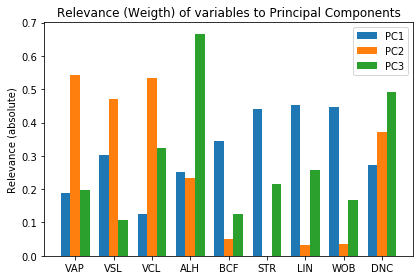

In [30]:
#PCA and analysis
motility_norm = norm(motility)
w, v = np.linalg.eig(motility_norm.cov())
print(w)
sets, comps = calc_pca(motility_norm, motility.columns.values)
show_pca_components(comps, motility.columns.values)

PCA of the whole dataset, analysis of loadings:
1. PC1 relates to the type of movement (straight/wobble)
2. PC2 relates to velocities
3. PC3 relates to type of movement too - but mostly oscillations

and thus, Variables chosen for clustering are:  <br>
- LIN (highest PC1)
- VCL (good PC2 and combo of PC1 and PC3, plus lin involves vap and vsl
- ALH (best PC3 and good PC1 and PC2)

In [36]:
new_motility = motility.loc[:,["LIN"]]
new_motility["VCL"] = pd.to_numeric(motility["VCL"])
new_motility["ALH"] = pd.to_numeric(motility["ALH"])
new_motility["LIN"] = pd.to_numeric(new_motility["LIN"])
new_motility_norm = norm(new_motility)

In [69]:
labels = clustering(new_motility_norm, 4)
plot_characteristics(new_motility, labels, 4,  new_motility.columns.values)

for cluster 0
LIN     46.308943
VCL    164.707317
ALH      7.347154
dtype: float64
LIN     4.485079
VCL    13.942601
ALH     1.009010
dtype: float64
for cluster 1
LIN     45.009434
VCL    206.198113
ALH      8.889623
dtype: float64
LIN     6.606879
VCL    13.120947
ALH     0.887325
dtype: float64
for cluster 2
LIN     44.0
VCL    155.0
ALH     59.1
dtype: float64
LIN    0.0
VCL    0.0
ALH    0.0
dtype: float64
for cluster 3
LIN     61.222222
VCL    153.092593
ALH      5.675309
dtype: float64
LIN     5.497474
VCL    25.042230
ALH     1.338650
dtype: float64


0